In [1]:
!pip install mlxtend
!pip install sklearn
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.ml.evaluation import RegressionEvaluator
from functools import reduce
from pyspark.mllib.linalg import SparseVector, DenseVector

In [2]:
df = spark.table('g6_all_features_csv').withColumn('Date2', to_timestamp("Date")).orderBy('Date2')

In [3]:
OriginalFeatures = ['japan_cases','italy_cases','uk_cases','germany_cases','france_cases','canada_ma','japan_ma','italy_ma','uk_ma','germany_ma',
'france_ma','canada_pt','japan_pt','italy_pt','uk_pt','germany_pt','france_pt','dow', 'canada_1lag','japan_1lag','italy_1lag','uk_1lag', 'germany_1lag','france_1lag','canada_2lag','japan_2lag','italy_2lag','uk_2lag','germany_2lag','france_2lag','canada_3lag','japan_3lag',
'italy_3lag','uk_3lag','germany_3lag','france_3lag']

ExternalFeatures = ['canada_cases','japan_cases','italy_cases','uk_cases','germany_cases','france_cases','canada_ma','japan_ma','italy_ma','uk_ma','germany_ma',
'france_ma','canada_pt','japan_pt','italy_pt','uk_pt','germany_pt','france_pt','dow','Canada_Outdoor_Mobility','Canada_indoorMobility',
'Germany_Outdoor_Mobility','Germany_indoorMobility','France_Outdoor_Mobility','France_indoorMobility','Japan_Outdoor_Mobility',
'Japan_indoorMobility','Italy_Outdoor_Mobility','Italy_indoorMobility','United_Kingdom_Outdoor_Mobility','United_Kingdom_indoorMobility', 'temp_canada','temp_uk','temp_italy','temp_japan','temp_germany','temp_france', 'canada_1lag','japan_1lag','italy_1lag','uk_1lag', 'germany_1lag','france_1lag','canada_2lag','japan_2lag','italy_2lag','uk_2lag','germany_2lag','france_2lag','canada_3lag','japan_3lag',
'italy_3lag','uk_3lag','germany_3lag','france_3lag']

In [4]:
import numpy as np
from multiprocessing.pool import ThreadPool
from pyspark.ml.tuning import _parallelFitTasks


class RollingKFoldCV(CrossValidator):
    """
    Modified CrossValidator to allow rolling k-fold cross validation using an increasing window. 
    Aimed to prevent data leakage associated with time series data (can't predict past using future data).
    """
        
    def _fit(self, dataset):
        est = self.getOrDefault(self.estimator)
        epm = self.getOrDefault(self.estimatorParamMaps)
        numModels = len(epm)
        eva = self.getOrDefault(self.evaluator)
        nFolds = self.getOrDefault(self.numFolds)
        seed = self.getOrDefault(self.seed)
        metrics = [0.0] * numModels

        # Use rolling window instead of random folds
        rowNumCol = self.uid + "_rownum"
        w = Window().orderBy(lit('A')) # Dummy window to create row number
        df = dataset.select("*", row_number().over(w).alias(rowNumCol))
        h = df.count()/(nFolds+1)

        pool = ThreadPool(processes=self.getParallelism())
        subModels = None
        collectSubModelsParam = self.getCollectSubModels()
        if collectSubModelsParam:
            subModels = [[None for j in range(numModels)] for i in range(nFolds)]

        for i in range(nFolds):
            # Get rolling (increasing) window
            validateLB = (i + 1) * h
            validateUB = (i + 2) * h
            validation = df.filter((df[rowNumCol] >= validateLB) & (df[rowNumCol] < validateUB)).cache()
            train = df.filter(df[rowNumCol] < validateLB).cache()

            tasks = _parallelFitTasks(est, train, eva, validation, epm, collectSubModelsParam)
            for j, metric, subModel in pool.imap_unordered(lambda f: f(), tasks):
                metrics[j] += (metric / nFolds)
                if collectSubModelsParam:
                    subModels[i][j] = subModel

            validation.unpersist()
            train.unpersist()

        if eva.isLargerBetter():
            bestIndex = np.argmax(metrics)
        else:
            bestIndex = np.argmin(metrics)
        bestModel = est.fit(dataset, epm[bestIndex])
        return self._copyValues(CrossValidatorModel(bestModel, metrics, subModels))

In [5]:
df_canada = df.withColumn('canada_1lead', lead('canada_cases').over(Window.orderBy('Date')))
df_canada = df_canada.withColumn('diff_canada', col('canada_1lead')-col('canada_cases'))
df_canada = df_canada.filter(col('diff_canada').isNotNull())

In [6]:
def lag_horizons(df, horizon):
  df_final = df.withColumn('target_lag'+str(horizon), lead(col('diff_canada'),horizon).over(Window.orderBy("Date"))) # target = diff_canada
  #df_final = df1.filter(col('target_lag'+str(horizon)).isNotNull())
  
  # define a dummy window 
  w = Window().partitionBy(lit('a')).orderBy(lit('a'))
  
  # split train and test set
  df_final1 = df_final.withColumn("row_num", row_number().over(w)/df_final.count())
  train_df = df_final1.where("row_num <= .75").drop("row_num")
  test_df = df_final1.where("row_num > .75").drop("row_num")
  test_df = test_df.filter(col('target_lag'+str(horizon)).isNotNull())
  return train_df, test_df

In [7]:
def pipeline(df, horizon, features, target):
  
  # remove target and lagged target from features
  fea = [s for s in features if s!=target] # shifted difference target, e.g. target_lag1
  feat = [s for s in fea if s!='canada_1lead'] # column that was used for differencing
  featu = [x for x in feat if x!='canada_cases'] # original target
  fea_final = [x for x in featu if x!='diff_canada'] # diffenreced target
  
  # obtain train and test

  train_df, test_df = lag_horizons(df, horizon)
  
  # define assembler 
  vectorAssembler = VectorAssembler(inputCols = fea_final, outputCol = 'features')
  
  # define model 
  RF = RandomForestRegressor(featuresCol='features', labelCol=target) 
  
  # define parameters for cross validation
  paramGrid = ParamGridBuilder() \
    .addGrid(RF.maxDepth, [2, 5, 10, 15, 20]) \
    .addGrid(RF.numTrees, [5, 10, 15, 20]) \
    .addGrid(RF.maxBins, [30])\
    .build()

  #define evaluator 
  evaluator = RegressionEvaluator(predictionCol="prediction", labelCol= target, metricName = 'r2')
  
  # build model
  crossval = RollingKFoldCV (estimator=RF,\
                          estimatorParamMaps=paramGrid,\
                          evaluator=evaluator,\
                          numFolds=3)
  
  # define pipeline
  pipelineCV = Pipeline(stages=[vectorAssembler, crossval])
  
  # fit train data
  model = pipelineCV.fit(train_df)
  
  # predict of test data
  prediction = model.transform(test_df)  
  
  return model, prediction

In [8]:
def original_diff(df, prediction, horizon, target):
  prediction.select('Date', 'canada_cases', target, 'prediction')
  # differenced target
  target_diff = prediction.select(target).rdd.flatMap(lambda x: x).collect()
  
  #differenced prediction
  pred_diff = prediction.select('prediction').rdd.flatMap(lambda x: x).collect()
  
  # define a dummy window 
  w = Window().partitionBy(lit('a')).orderBy(lit('a'))
  
  # get original test set
  df_final2 = df.withColumn("row_num", row_number().over(w)/df.count())
  test = df_final2.where("row_num > .75").drop("row_num")

  # shift by horizon to get original target data
  test = test.withColumn('canada_1lead'+str(horizon), lead('canada_1lead', horizon).over(Window.orderBy('Date')))
 
  # covnert to list
  country_lead = test.select('canada_1lead'+str(horizon)).rdd.flatMap(lambda x: x).collect()
  date = test.select('Date').rdd.flatMap(lambda x: x).collect()
  
  df_diff = spark.createDataFrame(zip(date, target_diff, pred_diff, country_lead), ['Date', 'target_diff', 'pred_diff', 'country_lead'])
  df_diff = df_diff.withColumn('actual_prediction', col('country_lead')-col('pred_diff'))
  df_diff = df_diff.withColumn('actual_target', col('country_lead')-col('target_diff'))
  
  return df_diff

In [9]:
def metrics(df_diff):
  # smape function
  s = df_diff.select((avg(abs(col('actual_prediction')-col('actual_target'))/\
                           (abs(col('actual_target'))+abs(col('actual_prediction'))))*100).alias('smape'))
  
  # R2 function
  evaluator = RegressionEvaluator(predictionCol="actual_prediction", labelCol="actual_target",metricName="r2")
  r2 = evaluator.evaluate(df_diff)
  return s, r2

In [10]:
def plot(df_diff, horizon):  
  pred = df_diff.withColumn('date_str', date_format(col("Date"), "yyyy-MM-dd"))
  plot = (pred.select('date_str', 'actual_prediction', 'actual_target')).toPandas()

  plt.figure(figsize=(8,5))  
  x = plot['date_str'].values
  y1 = plot['actual_target'].values
  y2 = plot['actual_prediction'].values
  plt.plot(x,y1, color = 'red')
  plt.plot(x,y2, color = 'black')
  plt.xticks(x[::3], rotation=45, ha='right')
  plt.title('Predicted Vs Actual Number of Cases, Horizon ='+str(horizon), fontsize=20)
  plt.xlabel('Date', fontsize=15)
  plt.ylabel('Number of Cases', fontsize=15)
  plt.legend(['Actual Cases', 'Predicted Cases'])
  plt.show()

In [11]:
model, prediction = pipeline(df_canada, 1, OriginalFeatures, 'target_lag1')
params = model.stages[-1].bestModel.extractParamMap()
#{p[0].name: p[1] for p in params.items()}

df_diff = original_diff(df_canada, prediction, 1, 'target_lag1')
s_1day, r2_1day = metrics(df_diff)

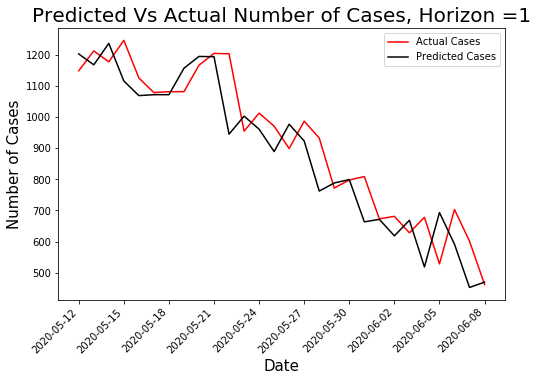

In [12]:
plot(df_diff, 1)

In [13]:
model, prediction= pipeline(df_canada, 7, OriginalFeatures, 'target_lag7')
params = model.stages[-1].bestModel.extractParamMap()

df_diff = original_diff(df_canada, prediction, 7, 'target_lag7')

s_7day, r2_7day = metrics(df_diff)

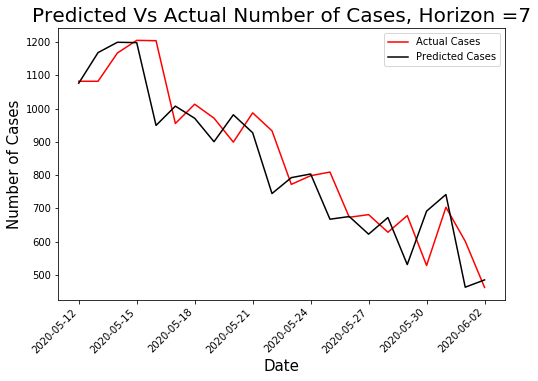

In [14]:
plot(df_diff, 7)

In [15]:
model, prediction = pipeline(df_canada, 14, OriginalFeatures, 'target_lag14')
params = model.stages[-1].bestModel.extractParamMap()

df_diff = original_diff(df_canada, prediction, 14, 'target_lag14')

s_14day, r2_14day = metrics(df_diff)

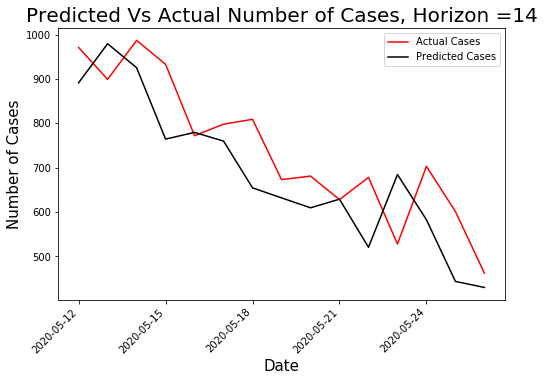

In [16]:
plot(df_diff, 14)

In [17]:
model, prediction = pipeline(df_canada, 21, OriginalFeatures, 'target_lag21')
params = model.stages[-1].bestModel.extractParamMap()


df_diff = original_diff(df_canada, prediction, 21, 'target_lag21')
s_21day, r2_21day = metrics(df_diff)

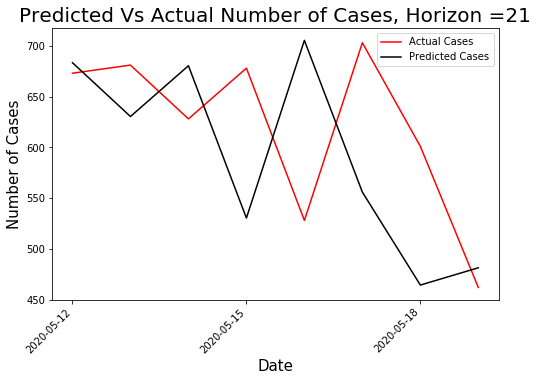

In [18]:
plot(df_diff, 21)

In [19]:
horizon = ['1 day', '7 day', '14 day', '21 day']
r2_original = [r2_1day, r2_7day, r2_14day, r2_21day]
smape_original = [s_1day.collect()[0].smape, s_7day.collect()[0].smape, s_14day.collect()[0].smape, s_21day.collect()[0].smape]

# create a dataframe that includes the metrics for all horizons

metrics_original = spark.createDataFrame(zip(horizon, r2_original, smape_original), ['Horizon', 'R2', 'sMAPE'])

# Extended Features- Canada

In [21]:
model, prediction= pipeline(df_canada, 1, ExternalFeatures, 'target_lag1')
params = model.stages[-1].bestModel.extractParamMap()

df_diff = original_diff(df_canada, prediction, 1, 'target_lag1')
s_E1, r2_E1 = metrics(df_diff)

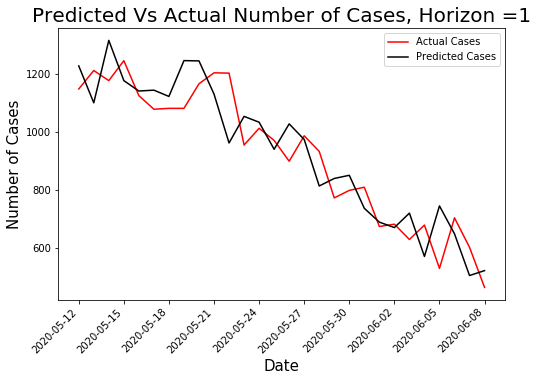

In [22]:
plot(df_diff, 1)

In [23]:
model, prediction= pipeline(df_canada, 7, ExternalFeatures, 'target_lag7')
params = model.stages[-1].bestModel.extractParamMap()

df_diff = original_diff(df_canada, prediction, 7, 'target_lag7')

s_E7, r2_E7 = metrics(df_diff)
s_E7.show()

+----------------+
 smape|
+----------------+
4.85638620163295|
+----------------+

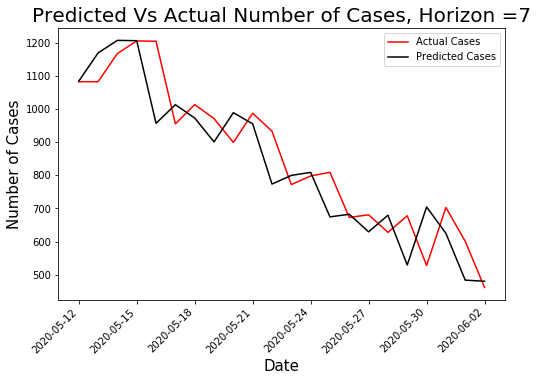

In [24]:
plot(df_diff, 7)

In [25]:
model, prediction= pipeline(df_canada, 14, ExternalFeatures, 'target_lag14')
params = model.stages[-1].bestModel.extractParamMap()

df_diff = original_diff(df_canada, prediction, 14, 'target_lag14')

s_E14, r2_E14 = metrics(df_diff)
s_E14.show()

+-----------------+
 smape|
+-----------------+
6.724585585665026|
+-----------------+

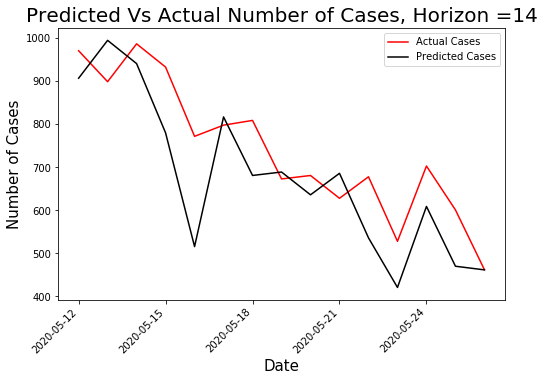

In [26]:
plot(df_diff, 14)

In [27]:
model, prediction= pipeline(df_canada, 21, ExternalFeatures, 'target_lag21')
params = model.stages[-1].bestModel.extractParamMap()

df_diff = original_diff(df_canada, prediction, 21, 'target_lag21')

s_E21, r2_E21 = metrics(df_diff)
s_E21.show()

+-----------------+
 smape|
+-----------------+
6.282049139366766|
+-----------------+

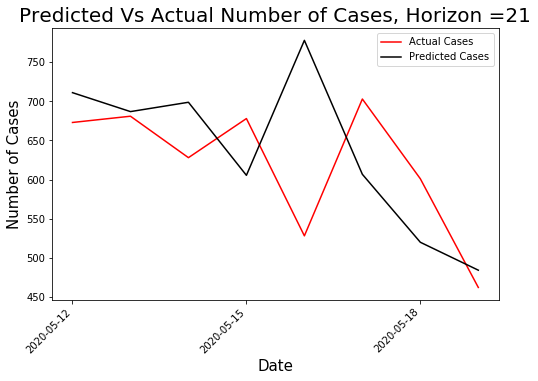

In [28]:
plot(df_diff, 21)

In [29]:
horizon = ['1 day', '7 day', '14 day', '21 day']
r2_extended = [r2_E1, r2_E7, r2_E14, r2_E21]
smape_extended = [s_E1.collect()[0].smape, s_E7.collect()[0].smape, s_E14.collect()[0].smape, s_E21.collect()[0].smape]

# create a dataframe that includes the metrics for all horizons

metrics_extended = spark.createDataFrame(zip(horizon, r2_extended, smape_extended), ['Horizon', 'R2', 'sMAPE'])
metrics_extended.show()

+-------+-------------------+-----------------+
Horizon| R2| sMAPE|
+-------+-------------------+-----------------+
 1 day| 0.8092928479431205|4.788494266318555|
 7 day| 0.7931110623587957| 4.85638620163295|
 14 day|0.47793065123936473|6.724585585665026|
 21 day|-0.7901844092659216|6.282049139366766|
+-------+-------------------+-----------------+